In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_edges = pd.read_csv('./data/exported_tableau/hrafnkel_edges_ordering1.csv', sep='\\t', dtype={"page": str, "order_id": str})
df_edges.fillna("", inplace=True)
df_edges.drop_duplicates(inplace=True) # remove duplicates created when joining tables (ordering IDs 37 & 38)
df_edges.drop(['Number of Records', 'action_description'], axis=1, inplace=True)
edges = df_edges.to_dict(orient="records")

df_nodes = pd.read_csv('./data/exported_tableau/hrafnkel_nodes_with_flags.csv', sep='\\t', dtype={"chapter": str, "page": str})
df_nodes.fillna("", inplace=True)
df_nodes.drop('Number of Records', axis=1, inplace=True)
nodes = df_nodes.to_dict(orient="records")

graph = {
    "edges": edges,
    "nodes": nodes
}

#with open('graph.json', 'w') as f:
#    json.dump(graph, f)


In [11]:
#edges
#df_edges.values
#df_edges.sort_values('action')
#df_edges

In [13]:
#empty_g = nx.DiGraph()
#g = nx.from_pandas_edgelist(df_edges, source='source', target='target', edge_attr=True, create_using=empty_g)
#nx.classes.function.get_edge_attributes(g, 'action description')
#nx.drawing.nx_pylab.draw(g, with_labels=True)

In [3]:
"""
Graph:

Node: an action/relation between two people. Has person1_id, and person2_id, action_type, action_description, chapter, page, action_id

Edge: a connection between two actions, defined by action_before and action_after, person_id, person_name
"""
colname_mapping = {'source': 'actioner_id', 'target': 'actionee_id', 'index': 'id', 'action': 'action_type', 'action description': 'action_description'}

# params
reduced = True
family = False

# prepare nodes from edges
nodes_ = df_edges
nodes_ = nodes_.reset_index()
nodes_ = nodes_.rename(colname_mapping, axis=1)
if reduced: 
    # remove actions "sibling", "descent" and "marriage"
    nodes_ = nodes_[~nodes_['action_type'].isin([0, 1, 2])]
if family:
    # only keep actions "sibling", "descent" and "marriage"
    nodes_ = nodes_[nodes_['action_type'].isin([0, 1, 2])]

#display(nodes_.iloc[20:40,:])

# create df of all action-person pairs
sources = nodes_.drop(['actionee_id'], axis=1).rename({'actioner_id': 'person_id'}, axis=1)
targets = nodes_.drop(['actioner_id'], axis=1).rename({'actionee_id': 'person_id'}, axis=1)
persons = pd.concat([sources, targets], axis=0)
#display(persons)

# create origin and last_seen action for each person
persons_max = persons.max()
display(persons_max)

unique_person_ids = persons['person_id'].unique()
#unique_person_names = persons['person_name'].unique()
#if len(unique_person_ids) is not len(unique_person_names):
#    print("Number of unique person IDs not the same as number of unique person names! Something is wrong!!")

max_id = persons_max['id']
origins = pd.DataFrame(range(max_id + 1, max_id + len(unique_person_ids) + 1), columns=['id'], dtype=int)
origins['action_type'] = -1
origins['action_description'] = 'origin'
origins['person_id'] = unique_person_ids
#origins['person_name'] = unique_person_names
origins['chapter'] = 0
origins['page'] = ''

max_id = origins['id'].max()
last_seen = pd.DataFrame(range(max_id + 1, max_id + len(unique_person_ids) + 1), columns=['id'], dtype=int)
last_seen['action_type'] = 25  # persons_max['action_type'] + 1
last_seen['action_description'] = 'last_seen'
last_seen['person_id'] = unique_person_ids
#last_seen['person_name'] = unique_person_names
last_seen['chapter'] = 17  # persons_max['chapter'] + 1
last_seen['page'] = ''

# add origin and last seen nodes to nodes_
origins_ = origins.rename({'person_id': 'actionee_id'}, axis=1)
origins_['actioner_id'] = -1
last_seen_ = last_seen.rename({'person_id': 'actioner_id'}, axis=1)
last_seen_['actionee_id'] = -2
nodes_ = pd.concat([nodes_, origins_, last_seen_])

# add origin actions to persons df
persons = pd.concat([persons, origins, last_seen], axis=0).reset_index(drop=True).sort_values(['person_id', 'chapter', 'page'])

# add person names
persons = persons.merge(df_nodes[['id', 'label']], how='left', left_on='person_id', right_on='id', suffixes=('', '_person'))
persons = persons.drop('id_person', axis=1).rename({'label': 'person_name'}, axis=1)

# create edges for each action-action pair sorted by chapter and page
groups = persons.groupby('person_id')

def make_edges(df):
    dropped1 = df.drop(['action_description', 'action_type'], axis=1)
    joined = dropped1.shift(1).join(dropped1, how='inner', lsuffix='_source', rsuffix='_target')
    dropped2 = joined.dropna()
    return dropped2.astype({'id_source': 'int64', 'chapter_source': 'int64', 'person_id_source': 'int64'})

edges_ = groups.apply(make_edges)

# dirty workaround thats used to have access to IDs, since "source" and "target" fields are replaced with the actual node 
# objects by d3js
edges_['id_source2'] = edges_['id_source']
edges_['id_target2'] = edges_['id_target']

# source and target columns will be used to connect edges to nodes
edges_ = edges_.rename({'id_source': 'source', 'id_target': 'target', 'person_name_source': 'person_name'}, axis=1)
edges_ = edges_.reset_index().drop(['level_1', 'person_id_source', 'person_id_target', 'person_name_target'], axis=1)
#display(nodes_)
#display(edges_)
#nodes_[nodes_['id']==2]


NameError: name 'df_edges' is not defined

In [2]:
if reduced:
    export_graph(nodes_, edges_, name='reduced')
    export_graph_csv(nodes_, edges_, name='reduced')
elif family:
    export_graph(nodes_, edges_, name='family')
    export_graph_csv(nodes_, edges_, name='family')
else:
    export_graph(nodes_, edges_, name='full')
    export_graph_csv(nodes_, edges_, name='full')

NameError: name 'reduced' is not defined

In [7]:
def export_graph(nodes, edges, name=''):
    nodes_export = nodes.to_dict(orient="records")
    edges_export = edges.to_dict(orient="records")
    graph = {
        "nodes": nodes_export,
        "edges": edges_export
    }

    with open(f'./data/exported_python/graph_{name}.json', 'w') as f:
        json.dump(graph, f)

def export_graph_csv(nodes, edges, name=''):
    with pd.ExcelWriter(f'./data/exported_python/graph_{name}.xlsx') as ew:
        nodes.to_excel(ew, sheet_name='nodes')
        edges.to_excel(ew, sheet_name='edges')

/Users/Moritz/Documents/TU/GD_Graph Drawing Algorithms/hrafnkel/.venv/lib/python3.7/site-packages/networkx/readwrite/graphml.py:893: UserWarning: No key type for id d3. Using string
  warnings.warn("No key type for id %s. Using string" % attr_id)
/Users/Moritz/Documents/TU/GD_Graph Drawing Algorithms/hrafnkel/.venv/lib/python3.7/site-packages/networkx/readwrite/graphml.py:893: UserWarning: No key type for id d4. Using string
  warnings.warn("No key type for id %s. Using string" % attr_id)
/Users/Moritz/Documents/TU/GD_Graph Drawing Algorithms/hrafnkel/.venv/lib/python3.7/site-packages/networkx/readwrite/graphml.py:893: UserWarning: No key type for id d5. Using string
  warnings.warn("No key type for id %s. Using string" % attr_id)
/Users/Moritz/Documents/TU/GD_Graph Drawing Algorithms/hrafnkel/.venv/lib/python3.7/site-packages/networkx/readwrite/graphml.py:893: UserWarning: No key type for id d6. Using string
  warnings.warn("No key type for id %s. Using string" % attr_id)
/Users/Morit

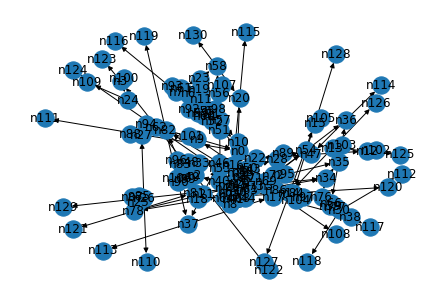

In [22]:
g = nx.read_graphml('./data/graph_reduced.graphml')
nx.drawing.nx_pylab.draw(g, with_labels=True)